In [13]:
import pandas as pd
import os
import skimage.io as io

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms
from transformers import ViTModel
import torchvision

In [15]:
torch.cuda.is_available()

True

In [16]:
network = "Phikon"
#network = 'Resnet'
transform_ops = [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225),
                        ),
                    ]

train_transform = transforms.Compose(transform_ops)

'''
if network == "Phikon":
    transform_ops_ = [transforms.Resize((224, 224))] + transform_ops
    train_transform = transforms.Compose(transform_ops_)
else:
    train_transform = transforms.Compose(transform_ops)
'''
train_transform

Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)

In [17]:
import skimage.io as io
from PIL import Image
class ImageDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = Image.open(self.df['image_path'][idx])

        label = self.df['gt'][idx]
        mask = label


        #if self.transforms is not None:
        img = self.transforms(img)
        return img, mask
# d = ImageDataset(df, _transform)

In [18]:
from transformers import ViTModel

class MyModel(nn.Module):
    def __init__(self, features_length, classes):
        super(MyModel, self).__init__()
        self.extractor = ViTModel.from_pretrained("owkin/phikon", add_pooling_layer=False)
        for param in self.extractor.parameters():
            param.requires_grad = False
        
        self.sigmoid1 = nn.Sigmoid()
        self.linear1 = nn.Linear(768, 128, bias=True)
        self.linear2 = nn.Linear(128, classes, bias=True)
        self.sigmoid2 = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        x = self.extractor(x).last_hidden_state[:, 0, :]
        x = self.sigmoid1(x)
        # max_values, _ = torch.topk(x, k=300, dim=1)
        # min_values, _ = torch.topk(-x, k=300, dim=1)  # Use negative values to find minimum
        # # # Concatenate max and min values
        # top_values = torch.cat([max_values, -min_values], dim=1)
        # # Flatten the tensor
        # top_values = top_values.view(-1, 20)  # batch_size x 20
        out = self.linear1(x)
        out = self.sigmoid2(out)
        #out = self.dropout(out)
        out = self.linear2(out)

        return out
# net = MyModel(768, 2)

In [19]:
class ResNetModel(nn.Module):
    def __init__(self, features_length, classes):
        super(ResNetModel, self).__init__()
        
        self.netG = torchvision.models.resnet101( weights='DEFAULT')
        self.netG.fc= nn.Linear(self.netG.fc.in_features, classes, bias=True)
        
    def forward(self, x):
        out = self.netG(x)
        #x = self.sigmoid1(x)
        # max_values, _ = torch.topk(x, k=300, dim=1)
        # min_values, _ = torch.topk(-x, k=300, dim=1)  # Use negative values to find minimum
        # # # Concatenate max and min values
        # top_values = torch.cat([max_values, -min_values], dim=1)
        # # Flatten the tensor
        # top_values = top_values.view(-1, 20)  # batch_size x 20
        #out = self.linear1(x)
        #out = self.sigmoid2(out)
        #out = self.dropout(out)
        #out = self.linear2(out)

        return out
# net = MyModel(768, 2)

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn.functional as F

def train(train_loader, model, criterion, optimizer, epoch, params, scheduler=None):
    model.train()
    preds, gt = [], []
    loss_val = []
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(params['device'], non_blocking=True)
        labels = labels.to(params['device'], non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_val.append(loss.item())
        # pred = outputs.sigmoid().sum(1).detach().round().cpu().numpy()
        # labels = labels.sum(1).detach().cpu().numpy()
        proba = F.softmax(outputs, dim=1)
        pred = torch.argmax(proba, dim=1)
        
        pred = pred.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        preds.extend(list(pred))
        gt.extend(list(labels))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    acc = accuracy_score(preds, gt)
    
    print( "Epoch: {epoch}. Train. {loss}, Acc. {accuracy}".format(epoch=epoch, loss = np.mean(loss_val), accuracy = acc))

    return model


def validate(val_loader, model, criterion, epoch, params):
    model.eval()
    preds, gt = [], []
    loss_val = []
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            inputs = inputs.to(params['device'], non_blocking=True)
            labels = labels.to(params['device'], non_blocking=True)
    
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss_val.append(loss.item())
            # pred = outputs.sigmoid().sum(1).detach().round().cpu().numpy()
            # labels = labels.sum(1).detach().cpu().numpy()
            proba = F.softmax(outputs, dim=1)
            pred = torch.argmax(proba, dim=1)
            pred = pred.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            
            preds.extend(list(pred))
            gt.extend(list(labels))
            
    acc = accuracy_score(preds, gt)

    print( "Epoch: {epoch}.  Val. {metric_monitor}, Acc. {accuracy}".format(epoch=epoch, 
                                                                            metric_monitor=np.mean(loss_val),
                                                                            accuracy = acc))
    
    return acc


def inference(test_loader, model, params):
    model.eval()
    with torch.no_grad():
        preds, gt = [], []
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs = inputs.to(params['device'], non_blocking=True)
            labels = labels.to(params['device'], non_blocking=True)
            outputs = model(inputs)
            # pred = outputs.sigmoid().sum(1).detach().round().cpu().numpy()
            # labels = labels.sum(1).detach().cpu().numpy()
            proba = F.softmax(outputs, dim=1)
            pred = torch.argmax(proba, dim=1)
            pred = pred.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            preds.extend(list(pred))
            gt.extend(list(labels))
            
        acc = accuracy_score(preds, gt)
        print(confusion_matrix(gt, preds))
    return acc, preds, gt
    

def train_and_validate(model, train_dataset, val_dataset, params, idx=None):
    # sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)
    # print(12, list(sampler))
    
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=params['batch_size'],
                                               num_workers=params['num_workers'],
                                               drop_last=True,
                                               # sampler=sampler,
                                               )

    val_loader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=params['batch_size'],
                                             shuffle=False, 
                                             num_workers=params['num_workers'], 
                                             )
    # {4: 290, 1: 284, 2: 170, 0: 94, 3: 6}
    weights = torch.tensor([0.0607, 0.0184, 0.0293, 0.8695, 0.0221]).to(params['device'])
    criterion = nn.CrossEntropyLoss(weight=weights).to(params['device'])
    #criterion = nn.CrossEntropyLoss().to(params['device'])
    # criterion = nn.BCEWithLogitsLoss().to(params['device'])
    optimizer = optim.AdamW(model.parameters(), 
                            lr=params['lr'], 
                            weight_decay=params["weight_decay"])
    
    for epoch in range(1, params["epochs"] + 1):
        model = train(train_loader, model, criterion, optimizer, epoch, params)
        score = validate(val_loader, model, criterion, epoch, params)
        if score > params['min_score']:
            params['min_score'] = score
            if idx:
                save = os.path.join(params['model_save_path'], 'snapshot'+str(idx))
            else:
                save = os.path.join(params['model_save_path'], 'snapshot')
            if not os.path.exists(save):
                os.makedirs(save)
                
            torch.save(model.state_dict(), os.path.join(save, "schowder.pt"))
            torch.save(model.state_dict(), os.path.join(save, "schowder_" + str(epoch) + '.pt'))
            print("============Save @ epoch {}============".format(epoch))
            
    model.load_state_dict(torch.load(os.path.join(save, "schowder.pt")))
    return model



In [21]:
params = {}
params["epochs"] = 100
params['device'] = 'cuda:2'
params['batch_size'] = 64 #phikon: 32 resnet: 20
params['num_workers'] = 4
params['lr'] = 0.001
params["weight_decay"] = 0.0005
params['model_save_path'] = './models/1_grade_classification_in_NLST_phikon_224/' # + str(time.time()) + '/'
params['train_dataset'] = 'train_224.csv'
params['val_dataset'] = 'val_224.csv'
params['test_dataset'] = 'test_224.csv'
params['min_score'] = 0
params['idx'] = 'weighted'


In [42]:

train_df = pd.read_csv(params['train_dataset'])
val_df = pd.read_csv(params['val_dataset'])
test_df = pd.read_csv(params['test_dataset'])
    
train_dataset = ImageDataset(train_df, train_transform)
val_dataset = ImageDataset(val_df, train_transform)
test_dataset = ImageDataset(test_df, train_transform)

#train_dataset = ImageDataset(train_df, transforms=None)
#val_dataset = ImageDataset(val_df, transforms=None)
#test_dataset = ImageDataset(test_df, transforms=None)

    
    
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                             batch_size=params['batch_size'],
                                             shuffle=False, 
                                             num_workers=params['num_workers'], 
                                             )
    
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=params['batch_size'],
                                             shuffle=False, 
                                             num_workers=params['num_workers'], 
                                             )

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                             batch_size=params['batch_size'],
                                             shuffle=False, 
                                             num_workers=params['num_workers'], 
                                             )

model = MyModel(768, 5)
model = model.to(params["device"])
weights = torch.tensor([0.0607, 0.0184, 0.0293, 0.8695, 0.0221]).to(params['device'])
criterion = nn.CrossEntropyLoss(weight=weights).to(params['device'])
optimizer = optim.AdamW(model.parameters(), 
                            lr=params['lr'], 
                            weight_decay=params["weight_decay"])

hist_train_loss = []
hist_val_loss = []
best_loss_val = 10000

save_freq = 2

# Training loop
num_epochs = 100
for epoch in range(params["epochs"] + 1):
    epoch_loss = 0
    val_loss = 0
    preds, gt = [], []
    print('Epoching:', epoch)
    
    model.train() 
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = data
        #print(inputs, labels)
        inputs = inputs.to(params['device'], non_blocking=True)
        labels = labels.to(params['device'], non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        #print(loss.item())
        
        proba = F.softmax(outputs, dim=1)
        pred = torch.argmax(proba, dim=1)
        
        pred = pred.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        preds.extend(list(pred))
        gt.extend(list(labels))
        
        loss.backward()
        optimizer.step()
    
    acc = accuracy_score(preds, gt)
    #print(gt)
    avg_loss_train = epoch_loss / len(train_loader)
    hist_train_loss.append(avg_loss_train)
    print( "Epoch: {epoch}.  Train. {metric_monitor}, Acc. {accuracy}".format(epoch=epoch, 
                                                                            metric_monitor=avg_loss_train,
                                                                            accuracy = acc))
    preds, gt = [], []
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            optimizer.zero_grad()
            inputs, labels = data
            inputs = inputs.to(params['device'], non_blocking=True)
            labels = labels.to(params['device'], non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
            proba = F.softmax(outputs, dim=1)
            pred = torch.argmax(proba, dim=1)
        
            pred = pred.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
        
            preds.extend(list(pred))
            gt.extend(list(labels))
        
    
        acc = accuracy_score(preds, gt)
        avg_loss_val = val_loss / len(val_loader)
        hist_val_loss.append(avg_loss_val)
        print( "Epoch: {epoch}.  Val. {metric_monitor}, Acc. {accuracy}".format(epoch=epoch, 
                                                                            metric_monitor=avg_loss_val,
                                                                            accuracy = acc))
    

    if epoch % save_freq == 0:
        torch.save(model.state_dict(),os.path.join(params['model_save_path'],str(epoch)+"_model.pt"))
        print("Saved model to {}".format(os.path.join(params['model_save_path'], str(epoch)+"_model.pt")))
    #print(best_loss_val)
    if hist_val_loss[-1] < best_loss_val:
        torch.save(model.state_dict(),os.path.join(params['model_save_path'],"model_best.pt"))
        print("Saved model to {}".format(os.path.join(params['model_save_path'], "model_best.pt")))
        best_loss_val = hist_val_loss[-1]





Some weights of the model checkpoint at owkin/phikon were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoching: 0
Epoch: 0.  Train. 2.240490059218099, Acc. 0.2663291139240506
Epoch: 0.  Val. 1.8144976794719696, Acc. 0.3111111111111111
Saved model to ./models/1_grade_classification_in_NLST_phikon_224/0_model.pt
Saved model to ./models/1_grade_classification_in_NLST_phikon_224/model_best.pt
Epoching: 1
Epoch: 1.  Train. 1.5696651916350088, Acc. 0.3032911392405063
Epoch: 1.  Val. 1.6836636066436768, Acc. 0.26666666666666666
Saved model to ./models/1_grade_classification_in_NLST_phikon_224/model_best.pt
Epoching: 2
Epoch: 2.  Train. 1.623638637604252, Acc. 0.19139240506329114
Epoch: 2.  Val. 1.6626582145690918, Acc. 0.31555555555555553
Saved model to ./models/1_grade_classification_in_NLST_phikon_224/2_model.pt
Saved model to ./models/1_grade_classification_in_NLST_phikon_224/model_best.pt
Epoching: 3
Epoch: 3.  Train. 1.5723367237275647, Acc. 0.30025316455696205
Epoch: 3.  Val. 1.648670107126236, Acc. 0.4711111111111111
Saved model to ./models/1_grade_classification_in_NLST_phikon_224/mod

In [49]:
save = os.path.join(params['model_save_path'])
model=MyModel(768,5)
model = model.to(params["device"])
model.load_state_dict(torch.load(os.path.join(save, "100_model.pt")))
weights = torch.tensor([0.0607, 0.0184, 0.0293, 0.8695, 0.0221]).to(params['device'])
criterion = nn.CrossEntropyLoss(weight=weights).to(params['device'])
optimizer = optim.AdamW(model.parameters(), 
                            lr=params['lr'], 
                            weight_decay=params["weight_decay"])

model

Some weights of the model checkpoint at owkin/phikon were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MyModel(
  (extractor): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_feat

In [50]:

save_freq = 2

for epoch in range(101,201):
    epoch_loss = 0
    val_loss = 0
    preds, gt = [], []
    print('Epoching:', epoch)
    
    model.train() 
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = data
        #print(inputs, labels)
        inputs = inputs.to(params['device'], non_blocking=True)
        labels = labels.to(params['device'], non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        #print(loss.item())
        
        proba = F.softmax(outputs, dim=1)
        pred = torch.argmax(proba, dim=1)
        
        pred = pred.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        preds.extend(list(pred))
        gt.extend(list(labels))
        
        loss.backward()
        optimizer.step()
    
    acc = accuracy_score(preds, gt)
    #print(gt)
    avg_loss_train = epoch_loss / len(train_loader)
    hist_train_loss.append(avg_loss_train)
    print( "Epoch: {epoch}.  Train. {metric_monitor}, Acc. {accuracy}".format(epoch=epoch, 
                                                                            metric_monitor=avg_loss_train,
                                                                            accuracy = acc))
    preds, gt = [], []
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            optimizer.zero_grad()
            inputs, labels = data
            inputs = inputs.to(params['device'], non_blocking=True)
            labels = labels.to(params['device'], non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
            proba = F.softmax(outputs, dim=1)
            pred = torch.argmax(proba, dim=1)
        
            pred = pred.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
        
            preds.extend(list(pred))
            gt.extend(list(labels))
        
    
        acc = accuracy_score(preds, gt)
        avg_loss_val = val_loss / len(val_loader)
        hist_val_loss.append(avg_loss_val)
        print( "Epoch: {epoch}.  Val. {metric_monitor}, Acc. {accuracy}".format(epoch=epoch, 
                                                                            metric_monitor=avg_loss_val,
                                                                            accuracy = acc))
    

    if epoch % save_freq == 0:
        torch.save(model.state_dict(),os.path.join(params['model_save_path'],str(epoch)+"_model.pt"))
        print("Saved model to {}".format(os.path.join(params['model_save_path'], str(epoch)+"_model.pt")))
    #print(best_loss_val)
    if hist_val_loss[-1] < best_loss_val:
        torch.save(model.state_dict(),os.path.join(params['model_save_path'],"model_best.pt"))
        print("Saved model to {}".format(os.path.join(params['model_save_path'], "model_best.pt")))
        best_loss_val = hist_val_loss[-1]





Epoching: 101
Epoch: 101.  Train. 0.6243859754214364, Acc. 0.7012658227848101
Epoch: 101.  Val. 2.0394673943519592, Acc. 0.56
Epoching: 102
Epoch: 102.  Train. 0.6863223718058679, Acc. 0.6835443037974683
Epoch: 102.  Val. 1.945836216211319, Acc. 0.5911111111111111
Saved model to ./models/1_grade_classification_in_NLST_phikon_224/102_model.pt
Epoching: 103
Epoch: 103.  Train. 0.5362324414234008, Acc. 0.7367088607594937
Epoch: 103.  Val. 1.976904422044754, Acc. 0.5866666666666667
Epoching: 104
Epoch: 104.  Train. 0.5432578685783571, Acc. 0.739240506329114
Epoch: 104.  Val. 2.0472925305366516, Acc. 0.5733333333333334
Saved model to ./models/1_grade_classification_in_NLST_phikon_224/104_model.pt
Epoching: 105
Epoch: 105.  Train. 0.5517358904884707, Acc. 0.7321518987341772
Epoch: 105.  Val. 2.0416150987148285, Acc. 0.5733333333333334
Epoching: 106
Epoch: 106.  Train. 0.5442118846601055, Acc. 0.7407594936708861
Epoch: 106.  Val. 2.07174551486969, Acc. 0.5733333333333334
Saved model to ./mode

In [54]:
save = os.path.join(params['model_save_path'])
model=MyModel(768,5)
model = model.to(params["device"])
model.load_state_dict(torch.load(os.path.join(save, "200_model.pt")))
weights = torch.tensor([0.0607, 0.0184, 0.0293, 0.8695, 0.0221]).to(params['device'])
criterion = nn.CrossEntropyLoss(weight=weights).to(params['device'])
optimizer = optim.AdamW(model.parameters(), 
                            lr=params['lr'], 
                            weight_decay=params["weight_decay"])


Some weights of the model checkpoint at owkin/phikon were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
save_freq = 2

for epoch in range(201,251):
    epoch_loss = 0
    val_loss = 0
    preds, gt = [], []
    print('Epoching:', epoch)
    
    model.train() 
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = data
        #print(inputs, labels)
        inputs = inputs.to(params['device'], non_blocking=True)
        labels = labels.to(params['device'], non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        #print(loss.item())
        
        proba = F.softmax(outputs, dim=1)
        pred = torch.argmax(proba, dim=1)
        
        pred = pred.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        preds.extend(list(pred))
        gt.extend(list(labels))
        
        loss.backward()
        optimizer.step()
    
    acc = accuracy_score(preds, gt)
    #print(gt)
    avg_loss_train = epoch_loss / len(train_loader)
    hist_train_loss.append(avg_loss_train)
    print( "Epoch: {epoch}.  Train. {metric_monitor}, Acc. {accuracy}".format(epoch=epoch, 
                                                                            metric_monitor=avg_loss_train,
                                                                            accuracy = acc))
    preds, gt = [], []
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            optimizer.zero_grad()
            inputs, labels = data
            inputs = inputs.to(params['device'], non_blocking=True)
            labels = labels.to(params['device'], non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
            proba = F.softmax(outputs, dim=1)
            pred = torch.argmax(proba, dim=1)
        
            pred = pred.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
        
            preds.extend(list(pred))
            gt.extend(list(labels))
        
    
        acc = accuracy_score(preds, gt)
        avg_loss_val = val_loss / len(val_loader)
        hist_val_loss.append(avg_loss_val)
        print( "Epoch: {epoch}.  Val. {metric_monitor}, Acc. {accuracy}".format(epoch=epoch, 
                                                                            metric_monitor=avg_loss_val,
                                                                            accuracy = acc))
    

    if epoch % save_freq == 0:
        torch.save(model.state_dict(),os.path.join(params['model_save_path'],str(epoch)+"_model.pt"))
        print("Saved model to {}".format(os.path.join(params['model_save_path'], str(epoch)+"_model.pt")))
    #print(best_loss_val)
    if hist_val_loss[-1] < best_loss_val:
        torch.save(model.state_dict(),os.path.join(params['model_save_path'],"model_best.pt"))
        print("Saved model to {}".format(os.path.join(params['model_save_path'], "model_best.pt")))
        best_loss_val = hist_val_loss[-1]




Epoching: 201
Epoch: 201.  Train. 0.2977245294248625, Acc. 0.8648101265822785
Epoch: 201.  Val. 3.744849056005478, Acc. 0.48
Epoching: 202
Epoch: 202.  Train. 0.3227869827420481, Acc. 0.859746835443038
Epoch: 202.  Val. 3.372103065252304, Acc. 0.5688888888888889
Saved model to ./models/1_grade_classification_in_NLST_phikon_224/202_model.pt
Epoching: 203
Epoch: 203.  Train. 0.2251427353870484, Acc. 0.899746835443038
Epoch: 203.  Val. 3.516812890768051, Acc. 0.56
Epoching: 204
Epoch: 204.  Train. 0.2125483498938622, Acc. 0.9048101265822784
Epoch: 204.  Val. 3.5507465600967407, Acc. 0.56
Saved model to ./models/1_grade_classification_in_NLST_phikon_224/204_model.pt
Epoching: 205
Epoch: 205.  Train. 0.2115632913285686, Acc. 0.9083544303797468
Epoch: 205.  Val. 3.545643448829651, Acc. 0.5555555555555556
Epoching: 206
Epoch: 206.  Train. 0.20771900059715395, Acc. 0.9129113924050632
Epoch: 206.  Val. 3.575462192296982, Acc. 0.56
Saved model to ./models/1_grade_classification_in_NLST_phikon_22

In [57]:
save = os.path.join(params['model_save_path'])
model=MyModel(768,5)
model = model.to(params["device"])
model.load_state_dict(torch.load(os.path.join(save, "250_model.pt")))
weights = torch.tensor([0.0607, 0.0184, 0.0293, 0.8695, 0.0221]).to(params['device'])
criterion = nn.CrossEntropyLoss(weight=weights).to(params['device'])
optimizer = optim.AdamW(model.parameters(), 
                            lr=params['lr'], 
                            weight_decay=params["weight_decay"])

Some weights of the model checkpoint at owkin/phikon were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
save_freq = 2

for epoch in range(251,301):
    epoch_loss = 0
    val_loss = 0
    preds, gt = [], []
    print('Epoching:', epoch)
    
    model.train() 
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, labels = data
        #print(inputs, labels)
        inputs = inputs.to(params['device'], non_blocking=True)
        labels = labels.to(params['device'], non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        #print(loss.item())
        
        proba = F.softmax(outputs, dim=1)
        pred = torch.argmax(proba, dim=1)
        
        pred = pred.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        preds.extend(list(pred))
        gt.extend(list(labels))
        
        loss.backward()
        optimizer.step()
    
    acc = accuracy_score(preds, gt)
    #print(gt)
    avg_loss_train = epoch_loss / len(train_loader)
    hist_train_loss.append(avg_loss_train)
    print( "Epoch: {epoch}.  Train. {metric_monitor}, Acc. {accuracy}".format(epoch=epoch, 
                                                                            metric_monitor=avg_loss_train,
                                                                            accuracy = acc))
    preds, gt = [], []
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            optimizer.zero_grad()
            inputs, labels = data
            inputs = inputs.to(params['device'], non_blocking=True)
            labels = labels.to(params['device'], non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
            proba = F.softmax(outputs, dim=1)
            pred = torch.argmax(proba, dim=1)
        
            pred = pred.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
        
            preds.extend(list(pred))
            gt.extend(list(labels))
        
    
        acc = accuracy_score(preds, gt)
        avg_loss_val = val_loss / len(val_loader)
        hist_val_loss.append(avg_loss_val)
        print( "Epoch: {epoch}.  Val. {metric_monitor}, Acc. {accuracy}".format(epoch=epoch, 
                                                                            metric_monitor=avg_loss_val,
                                                                            accuracy = acc))
    

    if epoch % save_freq == 0:
        torch.save(model.state_dict(),os.path.join(params['model_save_path'],str(epoch)+"_model.pt"))
        print("Saved model to {}".format(os.path.join(params['model_save_path'], str(epoch)+"_model.pt")))
    #print(best_loss_val)
    if hist_val_loss[-1] < best_loss_val:
        torch.save(model.state_dict(),os.path.join(params['model_save_path'],"model_best.pt"))
        print("Saved model to {}".format(os.path.join(params['model_save_path'], "model_best.pt")))
        best_loss_val = hist_val_loss[-1]




Epoching: 251
Epoch: 251.  Train. 0.18254636889398698, Acc. 0.9230379746835443
Epoch: 251.  Val. 4.796628504991531, Acc. 0.47555555555555556
Epoching: 252
Epoch: 252.  Train. 0.1734321338515128, Acc. 0.9311392405063291
Epoch: 252.  Val. 4.327044725418091, Acc. 0.56
Saved model to ./models/1_grade_classification_in_NLST_phikon_224/252_model.pt
Epoching: 253
Epoch: 253.  Train. 0.1244018622223408, Acc. 0.9478481012658228
Epoch: 253.  Val. 4.519078254699707, Acc. 0.56
Epoching: 254
Epoch: 254.  Train. 0.1260019192592271, Acc. 0.9473417721518987
Epoch: 254.  Val. 4.526518642902374, Acc. 0.56
Saved model to ./models/1_grade_classification_in_NLST_phikon_224/254_model.pt
Epoching: 255
Epoch: 255.  Train. 0.12635823092874018, Acc. 0.9443037974683545
Epoch: 255.  Val. 4.518211454153061, Acc. 0.56
Epoching: 256
Epoch: 256.  Train. 0.120955609806603, Acc. 0.9513924050632911
Epoch: 256.  Val. 4.543442904949188, Acc. 0.5555555555555556
Saved model to ./models/1_grade_classification_in_NLST_phikon_

In [23]:

test_df = pd.read_csv(params['test_dataset'])
test_dataset = ImageDataset(test_df, train_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                             batch_size=params['batch_size'],
                                             shuffle=False, 
                                             num_workers=params['num_workers'], 
                                             )

save = os.path.join(params['model_save_path'])
model=MyModel(768,5)
model = model.to(params["device"])
model.load_state_dict(torch.load(os.path.join(save, "200_model.pt")))
acc, preds, gt = inference(test_loader, model, params)
print(acc)

Some weights of the model checkpoint at owkin/phikon were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[[242  94  68   0  21]
 [ 34 756 366   2  32]
 [  9  49 583   0  14]
 [  2   5  22  15   1]
 [  9  23  69   0 909]]
0.7533834586466165


In [24]:
model=MyModel(768,5)
model = model.to(params["device"])
model.load_state_dict(torch.load(os.path.join(save, "102_model.pt")))
acc, preds, gt = inference(test_loader, model, params)
print(acc)

Some weights of the model checkpoint at owkin/phikon were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[[247  52  87   0  39]
 [103 542 467   3  75]
 [ 36  78 509   0  32]
 [  1   2  24  15   3]
 [  9   3  60   0 938]]
0.6769924812030075


In [17]:
model=MyModel(768,5)
model = model.to(params["device"])
model.load_state_dict(torch.load(os.path.join(save, "250_model.pt")))
acc, preds, gt = inference(test_loader, model, params)
print(acc)



Some weights of the model checkpoint at owkin/phikon were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[[229  92  85   0  19]
 [ 18 797 345   2  28]
 [  4  51 586   0  14]
 [  1   7  22  15   0]
 [  2  21  68   0 919]]
0.7657142857142857


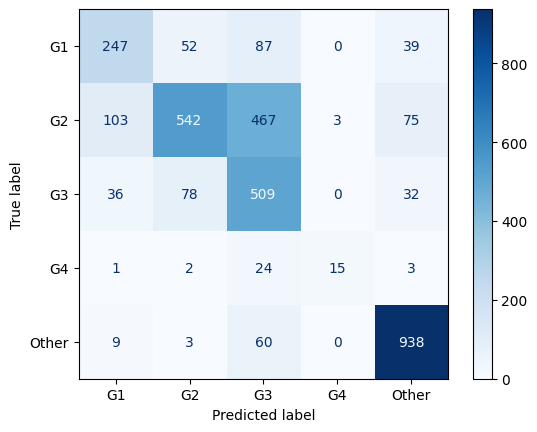

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       425
           1       0.80      0.46      0.58      1190
           2       0.44      0.78      0.56       655
           3       0.83      0.33      0.48        45
           4       0.86      0.93      0.89      1010

    accuracy                           0.68      3325
   macro avg       0.71      0.62      0.62      3325
weighted avg       0.73      0.68      0.67      3325



In [25]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = ['G1','G2','G3','G4','Other']
cm = confusion_matrix(gt, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

report = classification_report(gt, preds)
print("Classification Report:")
print(report)


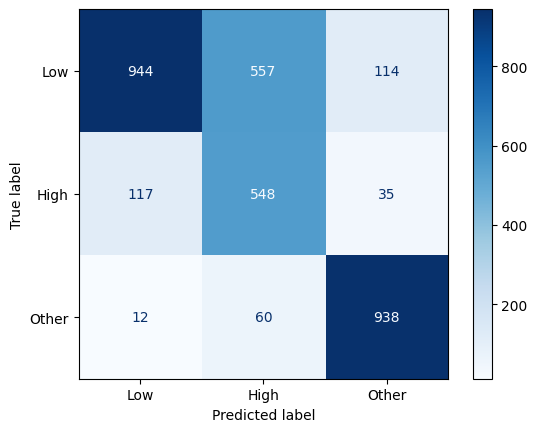

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.58      0.70      1615
           1       0.47      0.78      0.59       700
           2       0.86      0.93      0.89      1010

    accuracy                           0.73      3325
   macro avg       0.74      0.77      0.73      3325
weighted avg       0.79      0.73      0.74      3325



In [30]:
class_mapping = {
    0: 0,  # Map class 0 to new class 0
    1: 0,  # Map class 1 to new class 0
    2: 1,  # Map class 2 to new class 1
    3: 1,  # Map class 3 to new class 1
    4: 2   # Map class 4 to new class 2
}

# Convert 5-class list to 3-class list
new_gt = [class_mapping[class_id] for class_id in gt]
new_preds = [class_mapping[class_id] for class_id in preds]

labels = ['Low','High','Other']
cm = confusion_matrix(new_gt, new_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

report = classification_report(new_gt, new_preds)
print("Classification Report:")
print(report)

In [59]:
model=MyModel(768,5)
model = model.to(params["device"])
model.load_state_dict(torch.load(os.path.join(save, "300_model.pt")))
acc, preds, gt = inference(test_loader, model, params)
print(acc)

Some weights of the model checkpoint at owkin/phikon were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[[232  70 104   0  19]
 [ 11 716 431   0  32]
 [  4  29 607   0  15]
 [  0   5  24  15   1]
 [  1   8  59   0 942]]
0.7554887218045113
